In [2]:
!pip install -q kaggle

!mkdir -p ~/.kaggle



In [4]:
!cp kaggle.json ~/.kaggle/      #   (!cp [   API token file name   ] ~/.kaggle/)

!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory


In [5]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

100% 120M/121M [00:01<00:00, 64.1MB/s]
100% 121M/121M [00:01<00:00, 91.3MB/s]


In [6]:
from zipfile import ZipFile
zf = ZipFile('face-expression-recognition-dataset.zip', 'r')
zf.extractall('/content')
zf.close()

In [7]:
!pip install tensorflow-gpu

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [5]:
!nvidia-smi

Sun Aug 13 23:08:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [7]:
from tensorflow.keras.layers import Lambda,Input,Dense,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB2

In [8]:
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [9]:
IMAGE_SIZE=[224,224]
train_path='images/train'

valid_path='images/validation'

In [10]:
eff=EfficientNetB2(input_shape=IMAGE_SIZE+[3],include_top=False)

In [11]:
folders=glob('images/train/*')

In [12]:
folders

['images/train/fear',
 'images/train/angry',
 'images/train/disgust',
 'images/train/neutral',
 'images/train/happy',
 'images/train/sad',
 'images/train/surprise']

In [13]:
x=Flatten()(eff.output)

In [14]:
prediction=Dense(len(folders),activation='softmax')(x)

model=Model(inputs=eff.input,outputs=prediction)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [16]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
train_datagen=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)

test_datagen=ImageDataGenerator(rescale=1./255)

In [18]:
training_set=train_datagen.flow_from_directory(train_path,
                                               target_size=(224,224),batch_size=32,class_mode='categorical')

Found 28821 images belonging to 7 classes.


In [19]:
test_set=test_datagen.flow_from_directory(valid_path,
                                               target_size=(224,224),batch_size=32,class_mode='categorical')

Found 7066 images belonging to 7 classes.


In [20]:
r=model.fit_generator(training_set,validation_data=test_set,
                      epochs=3,
                      steps_per_epoch=len(training_set),
                      validation_steps=len(test_set))

<ipython-input-20-5e02e042333c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r=model.fit_generator(training_set,validation_data=test_set,


Epoch 1/3
901/901 [==============================] - 535s 522ms/step - loss: 1.6209 - accuracy: 0.4737 - val_loss: 3.2660 - val_accuracy: 0.1639
Epoch 2/3
901/901 [==============================] - 493s 547ms/step - loss: 1.1734 - accuracy: 0.5704 - val_loss: 2.9288 - val_accuracy: 0.2556
Epoch 3/3
901/901 [==============================] - 461s 511ms/step - loss: 1.1473 - accuracy: 0.5811 - val_loss: 2.4727 - val_accuracy: 0.1487


In [21]:
import matplotlib.pyplot as plt
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')



    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()

# print best epoch with best accuracy on validation

def get_best_epcoh(history):
    valid_acc = history.history['val_accuracy']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))
    return best_epoch


plot_results(r)
best_epoch =get_best_epcoh(r)

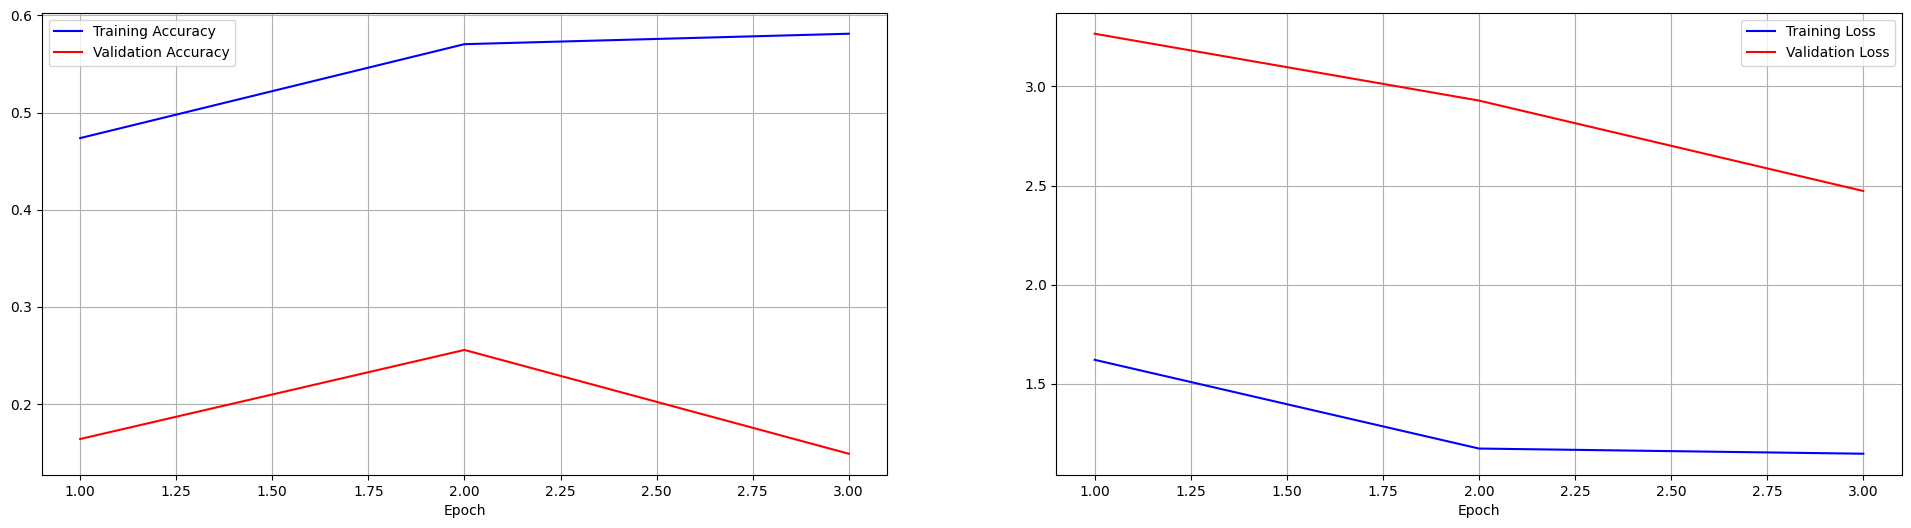

Best Validation Accuracy Score 0.25559, is for epoch 2


In [48]:
import matplotlib.pyplot as plt
plot_results(r)
best_epoch =get_best_epcoh(r)

In [45]:
emotion_labels = ["angry", "disgust", "fear", "happy", "neutral","sad", "surprise"]

im_path = "/content/images/images/train/happy/105.jpg"
img = tf.keras.utils.load_img(
    im_path, color_mode="grayscale", target_size=(224, 224)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

predicted_class_index = np.argmax(score)
confidence = 100 * np.max(score)
predicted_emotion = emotion_labels[predicted_class_index]

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(predicted_emotion, confidence)
)

1/1 [==============================] - 0s 28ms/step
This image most likely belongs to angry with a 18.64 percent confidence.
